# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

## Paso 0: Instalar librerías

In [17]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Paso 1: Instalar dependencias

In [18]:
pip install pandas requests

Note: you may need to restart the kernel to use updated packages.


## Paso 2: Descargar HTML

In [19]:
# URL de la página que es objeto del web scrapping
url = 'https://companies-market-cap-copy.vercel.app/index.html'

# Hacer la solicitud a la página
response = requests.get(url)

# Verificar que la solicitud fue exitosa
if response.status_code == 200:
    html_content = response.text # Guardar el HTML
else:
    print(f'Error al acceder a la página: {response.status_code}')

## Paso 3: Transforma el HTML

In [20]:
# Convertir el HTML en un objeto estructurado con BeautifulSoup

soup = BeautifulSoup(html_content, 'html.parser')  # Parsear el HTML con BeautifulSoup

# Buscar todas las tablas en el HTML

tables = soup.find_all('table')

print(f"Se encontraron {len(tables)} tablas en la página.")

# Si encontramos tablas, analizamos cuál contiene la evolución anual
for i, table in enumerate(tables):
    print(f"\nTabla {i + 1}:")
    print(table.prettify()[:500])  # Muestra los primeros 500 caracteres de cada tabla para análisis

# Seleccionar la Tabla 1
tabla_evolucion = tables[0]  # La primera tabla es la de evolución anual

# Extraer las filas de la tabla
filas = tabla_evolucion.find_all('tr')

# Crear una lista para almacenar los datos
data = []

# Iterar sobre las filas de la tabla
for fila in filas[1:]:  # Omitimos la primera fila (encabezados)
    columnas = fila.find_all('td')
    if len(columnas) >= 3:  # Asegurar que hay al menos 3 columnas
        year = columnas[0].text.strip()
        revenue = columnas[1].text.strip()
        change = columnas[2].text.strip()
        data.append([year, revenue, change])

# Crear un DataFrame de pandas con los datos extraídos
df = pd.DataFrame(data, columns=['Año', 'Ingresos', 'Cambio'])

# Ordenar los datos por la columna "Año" de menor a mayor 
df = df.sort_values("Año")

# Mostrar la tabla de datos
df

Se encontraron 2 tablas en la página.

Tabla 1:
<table class="table" style="width:100%">
 <thead>
  <tr>
   <th>
    Year
   </th>
   <th>
    Revenue
   </th>
   <th>
    Change
   </th>
  </tr>
 </thead>
 <tbody>
  <tr>
   <td>
    <span class="year">
     2024
    </span>
   </td>
   <td>
    $97.15 B
   </td>
   <td class="percentage-green">
    0.39%
   </td>
  </tr>
  <tr>
   <td>
    <span class="year">
     2023
    </span>
   </td>
   <td>
    $96.77 B
   </td>
   <td class="percentage-green">
    18.8%
   </td>
  </tr>
  <tr>
   <td

Tabla 2:
<table class="table w-100">
 <thead>
  <tr>
   <th>
    Company
   </th>
   <th>
    Revenue
   </th>
   <th>
    Revenue
    <span class="responsive-hidden">
     difference
    </span>
    <span class="responsive-shown">
     diff.
    </span>
   </th>
   <th>
    Country
   </th>
  </tr>
 </thead>
 <tbody>
  <tr>
   <td class="name-td">
    <a href="/apple/revenue/" style="pointer-events: none;">
     <div class="float-left pt-1">
   

,Año,Ingresos,Cambio
15,2009,$0.11 B,
14,2010,$0.11 B,4.29%
13,2011,$0.20 B,74.95%
12,2012,$0.41 B,102.34%
11,2013,$2.01 B,387.23%
10,2014,$3.19 B,58.85%
9,2015,$4.04 B,26.5%
8,2016,$7.00 B,73.01%
7,2017,$11.75 B,67.98%
6,2018,$21.46 B,82.51%


## Paso 4: Procesa el DataFrame

In [27]:
# Eliminar filas vacías
df = df.dropna()

# Remover '$' y 'B' de la columna "Ingresos" y convertir a número
df['Ingresos'] = df['Ingresos'].replace({'\$': '', ' B': ''}, regex=True).astype(float)

# Procesar la columna "Cambio" para eliminar valores vacíos y convertir en porcentaje decimal
df['Cambio'] = df['Cambio'].replace({'%': ''}, regex=True)
df['Cambio'] = pd.to_numeric(df['Cambio'], errors='coerce') / 100  # Convierte a float, ignorando valores no numéricos

# Eliminar filas donde "Cambio" sea NaN (valores vacíos que no se pudieron convertir)
df = df.dropna(subset=['Cambio'])

# Mostrar el DataFrame limpio
df

,Año,Ingresos,Cambio
1,2010,0.11,0.0429
2,2011,0.20,0.7495
3,2012,0.41,1.0234
4,2013,2.01,3.8723
5,2014,3.19,0.5885
6,2015,4.04,0.2650
7,2016,7.00,0.7301
8,2017,11.75,0.6798
9,2018,21.46,0.8251
10,2019,24.57,0.1452


## Paso 5: Almacena los datos en sqlite

In [28]:
# Crear (o conectar a) una base de datos SQLite
conn = sqlite3.connect('tesla_financials.db')

# Crear un cursor para ejecutar comandos SQL
cursor = conn.cursor()

# Crear una tabla para almacenar los datos (si no existe)
cursor.execute('''
    CREATE TABLE IF NOT EXISTS financials (
        Año INTEGER PRIMARY KEY,
        Ingresos REAL,
        Cambio REAL
    )
''')

# Insertar los datos en la tabla
df.to_sql('financials', conn, if_exists='replace', index=False)

# Guardar (commit) los cambios en la base de datos
conn.commit()

# Cerrar la conexión
conn.close()

# Confirmación
"Datos almacenados exitosamente en SQLite"

'Datos almacenados exitosamente en SQLite'

## Paso 6: Visualiza los datos

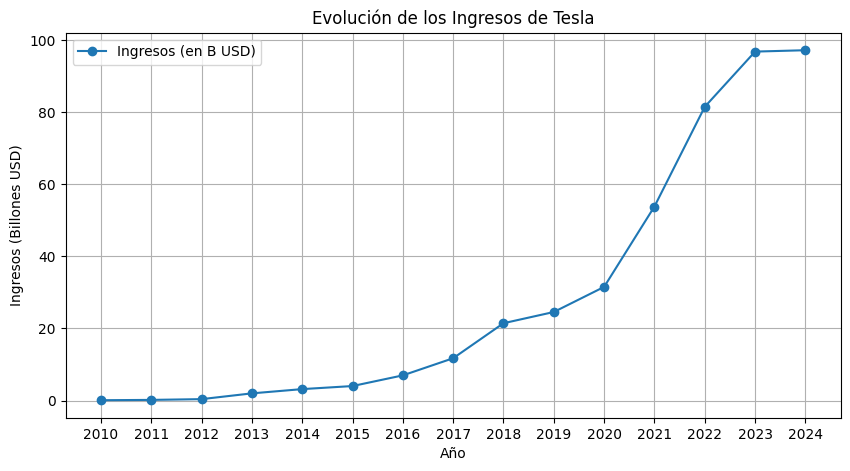

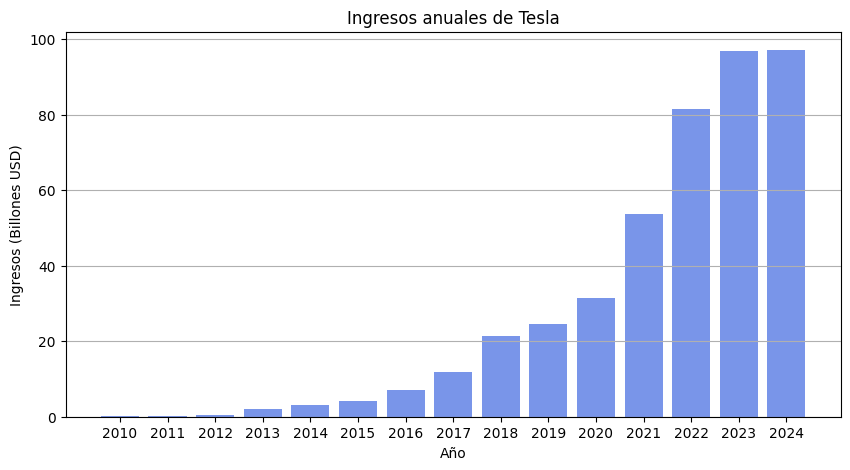

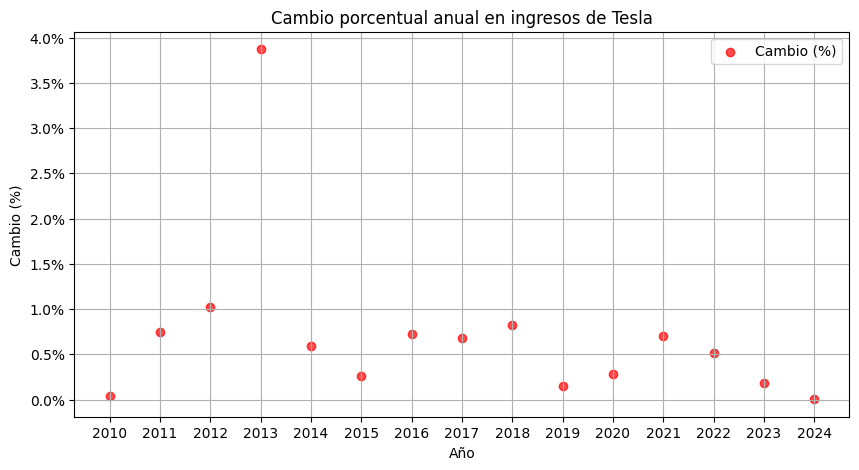

In [34]:
# Conectar a la base de datos y recuperar los datos
conn = sqlite3.connect('tesla_financials.db')
df = pd.read_sql('SELECT * FROM financials', conn)
conn.close()

# Crear un gráfico de líneas: Evolución de ingresos a lo largo del tiempo
plt.figure(figsize=(10,5))
plt.plot(df['Año'], df['Ingresos'], marker='o', linestyle='-', label='Ingresos (en B USD)')
plt.xlabel('Año')
plt.ylabel('Ingresos (Billones USD)')
plt.title('Evolución de los Ingresos de Tesla')
plt.legend()
plt.grid()
plt.show()

# Crear un gráfico de barras: Comparación de ingresos por año
plt.figure(figsize=(10,5))
plt.bar(df['Año'].astype(str), df['Ingresos'], color='royalblue', alpha=0.7)
plt.xlabel('Año')
plt.ylabel('Ingresos (Billones USD)')
plt.title('Ingresos anuales de Tesla')
plt.grid(axis='y')
plt.show()

# Crear un gráfico de dispersión: Cambio porcentual de ingresos vs Año

plt.figure(figsize=(10,5))
plt.scatter(df['Año'], df['Cambio'], color='red', alpha=0.7, label='Cambio (%)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%')) # Convertir los valores del eje Y a formato porcentaje
plt.xlabel('Año')
plt.ylabel('Cambio (%)')
plt.title('Cambio porcentual anual en ingresos de Tesla')
plt.legend()
plt.grid()
plt.show()

## Ejercicio extra

In [46]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# URL de la página que es objeto del web scrapping
url = 'https://companies-market-cap-copy.vercel.app/earnings.html'

# Hacer la solicitud a la página
response = requests.get(url)

# Verificar que la solicitud fue exitosa
if response.status_code == 200:
    html_content = response.text # Guardar el HTML
else:
    print(f'Error al acceder a la página: {response.status_code}')

# Convertir el HTML en un objeto estructurado con BeautifulSoup

soup = BeautifulSoup(html_content, 'html.parser')  # Parsear el HTML con BeautifulSoup

# Buscar todas las tablas en el HTML

tables = soup.find_all('table')

print(f"Se encontraron {len(tables)} tablas en la página.")

# Si encontramos tablas, analizamos cuál contiene ganancias anuales
for i, table in enumerate(tables):
    print(f"\nTabla {i + 1}:")
    print(table.prettify()[:500])  # Muestra los primeros 500 caracteres de cada tabla para análisis

# Seleccionar la Tabla 1
tabla_ganancias = tables[0]  # La primera tabla es la de evolución anual

# Extraer las filas de la tabla
filas = tabla_ganancias.find_all('tr')

# Crear una lista para almacenar los datos
data = []

# Iterar sobre las filas de la tabla
for fila in filas[1:]:  # Omitimos la primera fila (encabezados)
    columnas = fila.find_all('td')
    if len(columnas) >= 3:  # Asegurar que hay al menos 3 columnas
        year = columnas[0].text.strip()
        earnings = columnas[1].text.strip()
        change = columnas[2].text.strip()
        data.append([year, earnings, change])

# Crear un DataFrame de pandas con los datos extraídos
df = pd.DataFrame(data, columns=['Año', 'Ganancias', 'Cambio'])

# Ordenar los datos por la columna "Año" de menor a mayor 
df = df.sort_values("Año")

# Mostrar la tabla de datos
df

# Eliminar filas vacías
df = df.dropna()

# Función para convertir ganancias a números
def convertir_ganancias(valor):
    valor = valor.replace("$", "").replace(",", "").strip()  # Eliminar $ y espacios
    if "Million" in valor or "M" in valor:  # Convertir millones a números
        return float(valor.replace("Million", "").replace("M", "")) * 1e6
    elif "Billion" in valor or "B" in valor:  # Convertir billones a números
        return float(valor.replace("Billion", "").replace("B", "")) * 1e9
    else:
        return float(valor)  # Si no tiene unidades, devolver el número directamente

# Aplicar la función a la columna "Ganancias"
df["Ganancias"] = df["Ganancias"].apply(convertir_ganancias)

# Procesar la columna "Cambio" para eliminar valores vacíos y convertir en porcentaje decimal
df["Cambio"] = df["Cambio"].replace({'%': ''}, regex=True)
df["Cambio"] = pd.to_numeric(df["Cambio"], errors='coerce') / 100  # Convertir a float y manejar errores

# Eliminar filas donde "Cambio" sea NaN (valores vacíos que no se pudieron convertir)
df = df.dropna(subset=['Cambio'])

# Mostrar el DataFrame limpio
df

# Crear (o conectar a) una base de datos SQLite
conn = sqlite3.connect('tesla_earnings.db')

# Crear un cursor para ejecutar comandos SQL
cursor = conn.cursor()

# Crear una tabla para almacenar los datos (si no existe)
cursor.execute('''
    CREATE TABLE IF NOT EXISTS earnings (
        Año INTEGER PRIMARY KEY,
        Ganancias REAL,
        Cambio REAL
    )
''')

# Insertar los datos en la tabla
df.to_sql('earnings', conn, if_exists='replace', index=False)

# Guardar (commit) los cambios en la base de datos
conn.commit()

# Consultar la ganancia del último año disponible
query = "SELECT Año, Ganancias FROM earnings ORDER BY Año DESC LIMIT 1"
ultimo_año = pd.read_sql(query, conn)

# Cerrar la conexión
conn.close()

# Mostrar el resultado
año = ultimo_año.iloc[0, 0]  # Extrae el año
ganancias = ultimo_año.iloc[0, 1]  # Extrae las ganancias

print(f"Las ganancias de Tesla en el año {año} fueron de ${ganancias:,.2f}")


Se encontraron 2 tablas en la página.

Tabla 1:
<table class="table" style="width:100%">
 <thead>
  <tr>
   <th>
    Year
   </th>
   <th>
    Earnings
   </th>
   <th>
    Change
   </th>
  </tr>
 </thead>
 <tbody>
  <tr>
   <td>
    <span class="year">
     2024
    </span>
   </td>
   <td>
    $8.73 B
   </td>
   <td class="percentage-red">
    -13.81%
   </td>
  </tr>
  <tr>
   <td>
    <span class="year">
     2023
    </span>
   </td>
   <td>
    $10.12 B
   </td>
   <td class="percentage-red">
    -27.18%
   </td>
  </tr>
  <tr>
   <td

Tabla 2:
<table class="table w-100">
 <thead>
  <tr>
   <th>
    Company
   </th>
   <th>
    Earnings
   </th>
   <th>
    Earnings
    <span class="responsive-hidden">
     difference
    </span>
    <span class="responsive-shown">
     diff.
    </span>
   </th>
   <th>
    Country
   </th>
  </tr>
 </thead>
 <tbody>
  <tr>
   <td class="name-td">
    <a href="/apple/earnings/" style="pointer-events: none;">
     <div class="float-left pt-1">
